In [23]:
from libs.corp_df import *
from libs.get_docs import get_pickled_docs as gpd
from libs.dim_red import *
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
# retrieve documents
print('Retrieving Documents...')
cdir = 'corpora/articles_stage2.pickle'
docs = gpd(cdir, verbose=True)

Retrieving Documents...
TIME ELAPSED: 29.0s


In [28]:
def getInfo(root):
    dfdict = {'form': [], 'lemma': [], 'embedding': [], 
              'shoresh': [], 'binyan': [], 'morphemes': [], 'valid_embedding': []}
    for doc in tqdm(docs):
        for pg in doc:
            for sent in pg:
                for tok in sent:
                    for lem in tok:
                        if lem.pos_tag in ['BNT', 'BN', 'VB']:
                            if lem.shoresh == root and lem.binyan is not None:
                                dfdict['form'].append(lem.form)
                                dfdict['lemma'].append(lem.lemma)
                                dfdict['embedding'].append(tok.embedding)
                                dfdict['shoresh'].append(lem.shoresh)
                                dfdict['binyan'].append(lem.binyan)
                                dfdict['morphemes'].append(len(tok.lemmas))
                                validEmbedding = 1 if tok.tokenizer_index != 1 else 0
                                dfdict['valid_embedding'].append(validEmbedding)
                                    
    df = pd.DataFrame(dfdict)
    
    print('performing dimensionality reduction...')
    for i in tqdm(range(12)):
        print('LAYER: {}'.format(i))
        df['x_' + str(i)], df['y_' + str(i)] =  tsne(np.array([ten[i].numpy() for ten in dfdict['embedding']]), 
                                                     verbose=True)
        print()
        
    return df

In [46]:
df = getInfo('קבל')
for group, dff in df.groupby('binyan'):
    print('Binyan: {}'.format(group))
    print('# Records: {}'.format(len(dff)))

  0%|          | 0/524 [00:00<?, ?it/s]

performing dimensionality reduction...


  0%|          | 0/12 [00:00<?, ?it/s]

LAYER: 0
TIME ELAPSED: 0.73

LAYER: 1
TIME ELAPSED: 0.78

LAYER: 2
TIME ELAPSED: 0.76

LAYER: 3
TIME ELAPSED: 0.77

LAYER: 4
TIME ELAPSED: 0.81

LAYER: 5
TIME ELAPSED: 0.73

LAYER: 6
TIME ELAPSED: 0.76

LAYER: 7
TIME ELAPSED: 0.76

LAYER: 8
TIME ELAPSED: 0.74

LAYER: 9
TIME ELAPSED: 0.82

LAYER: 10
TIME ELAPSED: 0.81

LAYER: 11
TIME ELAPSED: 0.72

Binyan: HIFIL
# Records: 3
Binyan: HITPAEL
# Records: 22
Binyan: PAAL
# Records: 3
Binyan: PIEL
# Records: 210


In [43]:
def getxylabs(layer):
    l = str(layer)
    return 'x_' + l, 'y_' + l

def graphBinyanim(df, saveDir=None, excludeBadEmbeds=True, excludeCompounds=True):
    testdf = df[df['valid_embedding'] == 1] if excludeBadEmbeds else df
    testdf = testdf[testdf['morphemes'] == 1] if excludeCompounds else testdf
    fig, axes = plt.subplots(3, 4, figsize=(24,18))
    
    fig.suptitle('|'.join([n[::-1] for n in df['shoresh'].unique()]))
    for layer, ax in zip(range(12), axes.reshape(-1)):
        for cat, dff in testdf.groupby('binyan'):
            x, y = getxylabs(layer)
            ax.scatter(dff[x], dff[y], label=cat)
            
        ax.set_title('Layer {}'.format(layer))
        ax.legend()
        
    if saveDir:
        plt.savefig(saveDir)
        
    plt.show()

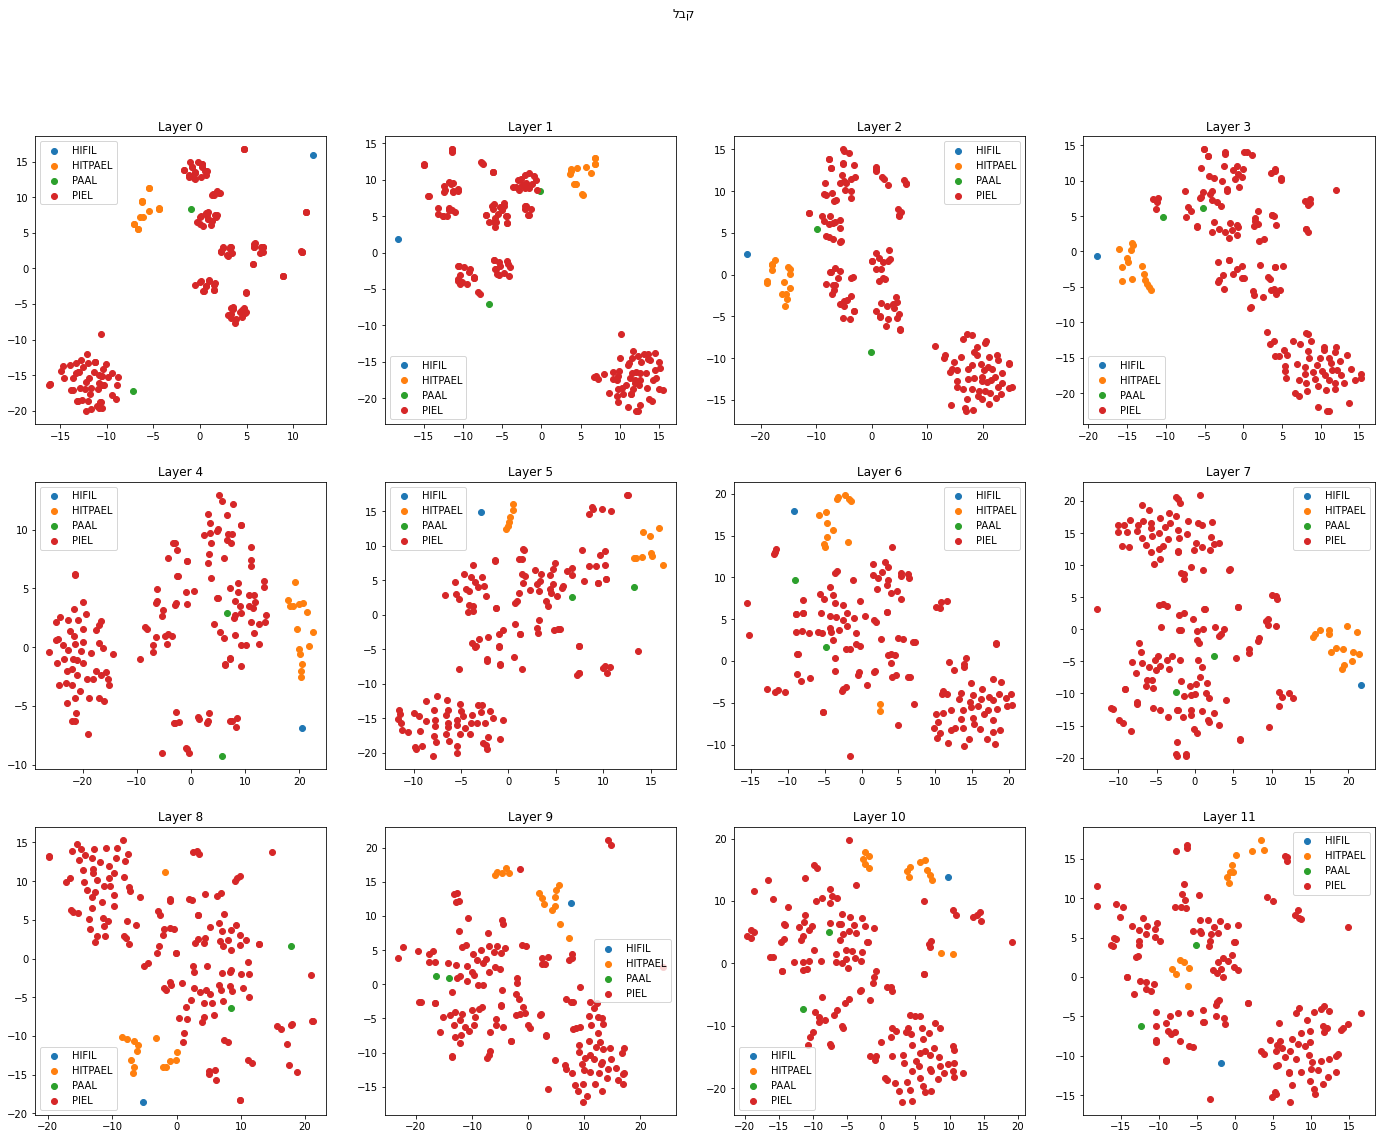

In [47]:
graphBinyanim(df)

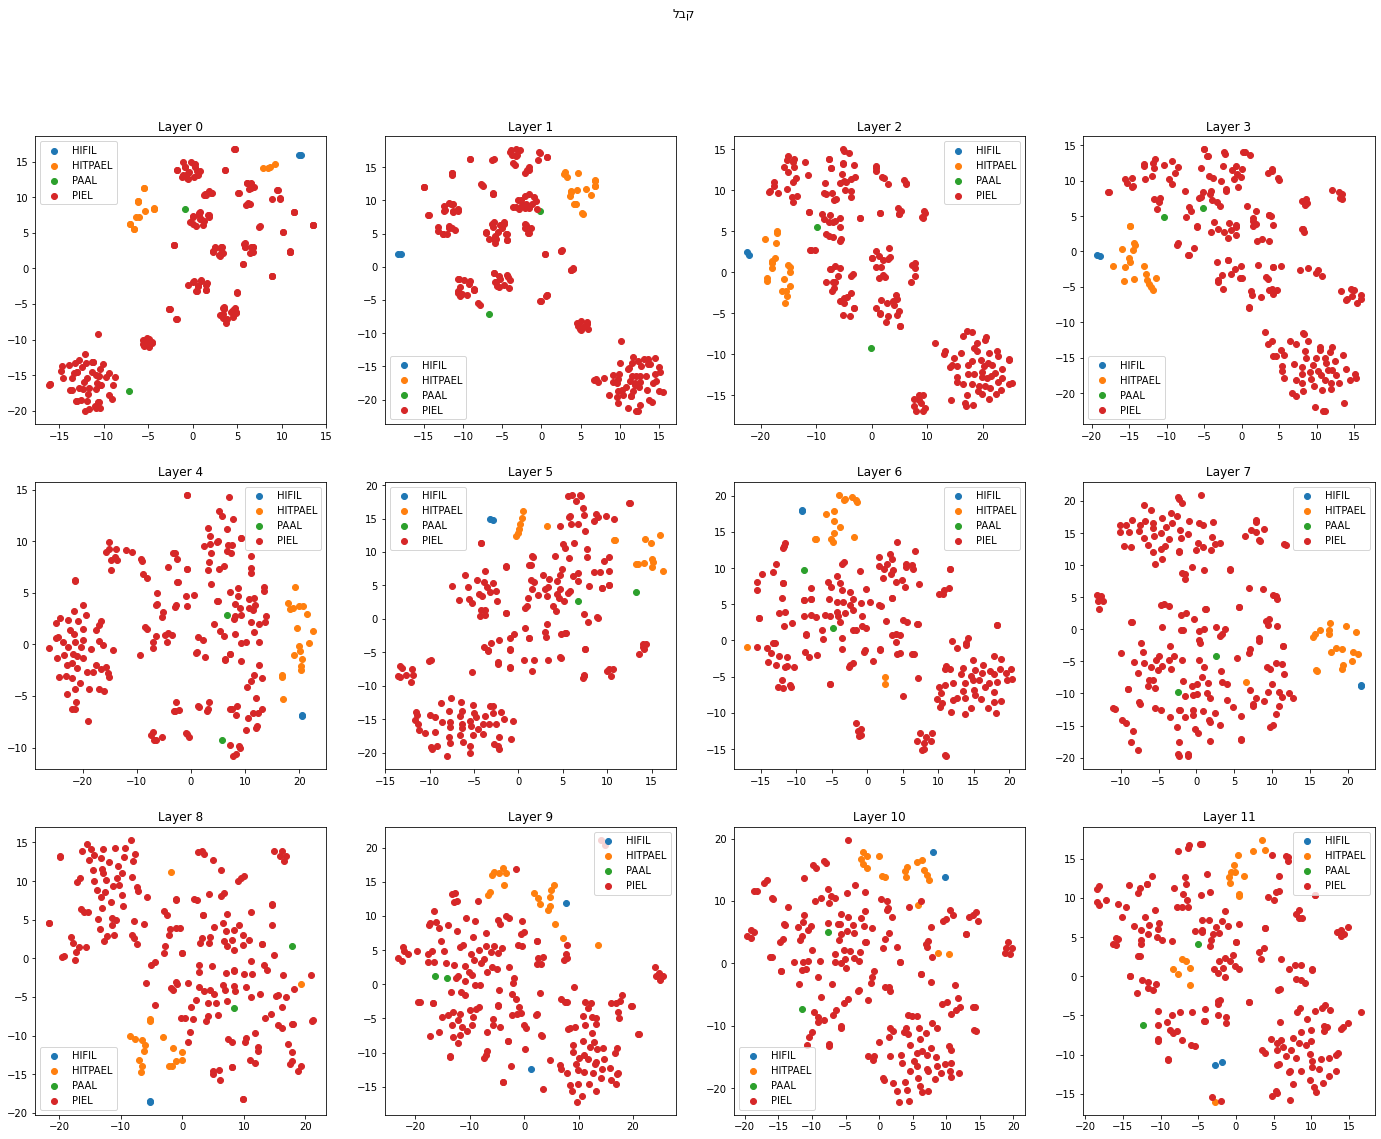

In [48]:
graphBinyanim(df, excludeCompounds=False)